# Original Algorithm applied with GLPK
This notebook contains the implementation I used for Gurobi, applied to GLPKm where I mainly use XGBoost to identify the important features, and use those in the BNP-OCT algorithm. It doesn't produce a reasonable solution, but instead uses the heuristic solution, to produce an output where everything is identified as Not-Fraud, possibly due to GLPK being more inefficient than Gurobi.

In [1]:
from numpy import loadtxt
import pandas as pd
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

from lsopt.tree import OptimalTreeClassifier ## M-OCT propsed by Liu & Allen
from lsopt.tree import BinNodePenaltyOptimalTreeClassifier ## BNP-OCT propsed by Liu & Allen
# from lsopt.tree import OldOptimalTreeClassifier ## OCT proposed by Bertsimas & Dunn

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import tree 

import graphviz

%load_ext autoreload
%autoreload 2

In [2]:
data_path_fraud = './data/fraud_data_m_oct_ready.csv'
fraud_data = pd.read_csv(data_path_fraud)
fraud_data

,phy_same,phy_count,period,periodadmt,age,alife,provider_InscClaimAmtReimbursed_mean,provider_DeductibleAmtPaid_mean,provider_NoOfMonths_PartACov_mean,provider_NoOfMonths_PartBCov_mean,...,diag1_OPAnnualDeductibleAmt_mean,diag1_InscClaimAmtReimbursed_std,diag1_DeductibleAmtPaid_std,diag1_NoOfMonths_PartACov_std,diag1_NoOfMonths_PartBCov_std,diag1_IPAnnualReimbursementAmt_std,diag1_IPAnnualDeductibleAmt_std,diag1_OPAnnualReimbursementAmt_std,diag1_OPAnnualDeductibleAmt_std,PotentialFraud
0,2.960000,1.600000,1.440000,1.000000,80.240000,1.000000,4185.600000,213.600000,12.000000,12.000000,...,543.045084,3482.066310,161.353027,0.569945,0.424192,12941.552350,1205.297144,2450.076771,661.506672,Not-Fraud
1,2.439394,1.530303,3.674242,2.424242,71.371212,0.992424,4588.409091,502.166667,11.818182,11.871212,...,676.313985,4017.871066,260.257069,0.726572,0.653285,12620.604410,1226.306633,3369.338617,848.213675,Fraud
2,2.818792,1.604027,1.429530,0.000000,73.516779,0.993289,350.134228,2.080537,11.865772,11.959732,...,694.246881,1536.290845,113.086257,0.667719,0.577420,11016.516940,1111.592405,2972.377916,808.138208,Not-Fraud
3,2.731330,1.599142,1.088412,0.000000,71.783691,0.996567,241.124463,3.175966,11.907296,11.939914,...,630.805985,1234.005090,91.141252,0.657071,0.565930,10021.329570,957.701391,2727.944083,737.419878,Fraud
4,2.736111,1.527778,0.958333,0.222222,70.583333,0.986111,468.194444,45.333333,11.833333,11.833333,...,606.550334,1519.425993,103.302166,0.626542,0.520122,10565.761430,1126.358206,2486.827069,682.279276,Not-Fraud
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004,2.548387,1.548387,2.806452,0.000000,75.677419,1.000000,127.741935,1.612903,12.000000,12.000000,...,539.926413,1278.578369,105.316369,0.642724,0.506470,10069.067870,1048.496358,2331.087492,676.226785,Not-Fraud
1005,2.500000,1.500000,0.100000,0.000000,78.000000,1.000000,72.000000,0.000000,12.000000,12.000000,...,544.784235,589.615472,61.510304,0.690826,0.473344,10885.075840,1026.840019,2547.341333,723.822292,Not-Fraud
1006,3.000000,2.000000,0.000000,0.000000,74.000000,1.000000,50.000000,0.000000,12.000000,12.000000,...,613.157895,4778.012673,463.684066,0.600751,0.710275,13241.321690,1469.095843,3203.267596,911.406530,Not-Fraud
1007,2.333333,1.333333,2.266667,0.000000,73.933333,1.000000,296.000000,0.000000,12.000000,12.000000,...,566.953462,2506.463260,131.832995,0.726815,0.354062,11262.841610,1196.045563,2691.729344,736.415563,Not-Fraud


In [3]:
X = fraud_data.iloc[:, 0:47].to_numpy()

In [4]:
y = fraud_data["PotentialFraud"].apply(lambda val: 0 if val == "Not-Fraud" else 1).to_numpy()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [6]:
model = XGBClassifier()

In [7]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [8]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]    
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))  

Accuracy: 93.56%


In [9]:
thresholds = sort(model.feature_importances_)
max_acc = -1
true_thresh = -1
for thresh in thresholds:
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    
    predictions = [round(value) for value in y_pred]
    
    accuracy = accuracy_score(y_test, predictions)
    if accuracy >= max_acc and select_X_train.shape[1] < 20:
        max_acc = accuracy
        true_thresh = thresh
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.000, n=47, Accuracy: 93.56%
Thresh=0.000, n=47, Accuracy: 93.56%
Thresh=0.000, n=47, Accuracy: 93.56%
Thresh=0.000, n=47, Accuracy: 93.56%
Thresh=0.000, n=47, Accuracy: 93.56%
Thresh=0.000, n=47, Accuracy: 93.56%
Thresh=0.005, n=41, Accuracy: 93.56%
Thresh=0.009, n=40, Accuracy: 94.06%
Thresh=0.009, n=39, Accuracy: 94.06%
Thresh=0.009, n=38, Accuracy: 94.06%
Thresh=0.010, n=37, Accuracy: 94.06%
Thresh=0.011, n=36, Accuracy: 94.55%
Thresh=0.011, n=35, Accuracy: 94.06%
Thresh=0.011, n=34, Accuracy: 94.06%
Thresh=0.012, n=33, Accuracy: 95.05%
Thresh=0.012, n=32, Accuracy: 94.06%
Thresh=0.012, n=31, Accuracy: 95.54%
Thresh=0.012, n=30, Accuracy: 94.06%
Thresh=0.013, n=29, Accuracy: 95.05%
Thresh=0.013, n=28, Accuracy: 93.56%
Thresh=0.014, n=27, Accuracy: 94.06%
Thresh=0.014, n=26, Accuracy: 94.06%
Thresh=0.014, n=25, Accuracy: 94.06%
Thresh=0.015, n=24, Accuracy: 95.54%
Thresh=0.015, n=23, Accuracy: 94.55%
Thresh=0.016, n=22, Accuracy: 93.56%
Thresh=0.017, n=21, Accuracy: 94.06%
T

In [10]:
print(true_thresh)

0.032147862


In [40]:
from lsopt.tree import OptimalTreeClassifier ## M-OCT propsed by Liu & Allen
from lsopt.tree import BinNodePenaltyOptimalTreeClassifier ## BNP-OCT propsed by Liu & Allen
selection = SelectFromModel(model, threshold=true_thresh, prefit=True)
select_X_train = selection.transform(X_train)

# OCT parameters
max_depth = 3
min_samples_leaf = 7
alpha = 0.005
time_limit = 40  # minute
mip_gap_tol = 0.05  # optimal gap percentage
mip_focus = 'balance'
mip_polish_time = None
warm_start = False
log_file = None
fp_heur = True
backtrack = "bestb"

# Construct BNP-OCT classifier
selection_model = BinNodePenaltyOptimalTreeClassifier(max_depth=max_depth,min_samples_leaf=min_samples_leaf,
                                  alpha=alpha,
                                  criterion="gini",
                                  solver="glpk",
                                  time_limit=time_limit,
                                  verbose=True,
                                  warm_start=warm_start,
                                  log_file=log_file,
                                  solver_options={'mip_cuts': None,
                                                  'mip_gap_tol': mip_gap_tol,
                                                  'fp_heur': fp_heur,
                                                  'backtrack': backtrack
                                                  }
                                  )

In [12]:
print(select_X_train.shape)

(807, 7)


In [37]:
names = []
for i in range(len(model.feature_importances_)):
    if model.feature_importances_[i] >= true_thresh:
        names.append(fraud_data.iloc[:, [i]].columns[0])
print(len(names))

7


In [41]:
selection_model.fit(select_X_train, y_train)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --tmlim 2400 --mipgap 0.05 --fpump --bestb --write /var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmpo7j8b4rt.glpk.raw
 --wglp /var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmpevmn_hcz.glpk.glp
 --cpxlp /var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmpg1r4pvia.pyomo.lp
Reading problem data from '/var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmpg1r4pvia.pyomo.lp'...
/var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmpg1r4pvia.pyomo.lp:523330: warning: lower bound of variable 'x11' redefined
/var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmpg1r4pvia.pyomo.lp:523330: warning: upper bound of variable 'x11' redefined
26210 rows, 6622 columns, 438053 non-zeros
133 integer variables, all of which are binary
523463 lines were read
Writing problem data to '/var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmpevmn_hcz.glpk.glp'...
503566 lines were written
GLPK Integer Optimizer 5.0
26210 rows, 6622 columns, 

In [42]:
# Make prediction
selection = SelectFromModel(model, threshold=true_thresh, prefit=True)
select_X_test = selection.transform(X_train)
y_pred = selection_model.predict(X=select_X_train)
y_pred_prob = selection_model.predict_proba(X=select_X_train)

# Check confusion matrix
print("Confusion Matrix :")
print(confusion_matrix(y_true=y_train,
                       y_pred=y_pred))

print(classification_report(y_true=y_train,
                            y_pred=y_pred))

# Plot Optimal Tree
feature_names = names
class_names = ['Not-Fraud', 'Fraud']

dot_data = tree.export_graphviz(selection_model,
                                out_file=None,
                                feature_names=feature_names,
                                class_names=class_names,
                                label='all',
                                impurity=True,
                                node_ids=True,
                                filled=True,
                                rounded=True,
                                leaves_parallel=True,
                                special_characters=False)

graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render(filename='optimal_tree_fraud', directory='', view=True)

Confusion Matrix :
[[716   2]
 [ 74  15]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       718
           1       0.88      0.17      0.28        89

    accuracy                           0.91       807
   macro avg       0.89      0.58      0.62       807
weighted avg       0.90      0.91      0.88       807



'optimal_tree_fraud.png'

In [46]:
num = 0
for element in y_train:
    if element == 1:
        num += 1
print(num)


89


In [ ]:
count = 0
for element in y_pred:
    if element == 1:
        count += 1
print(count)

0


In [ ]:
print(selection_model)

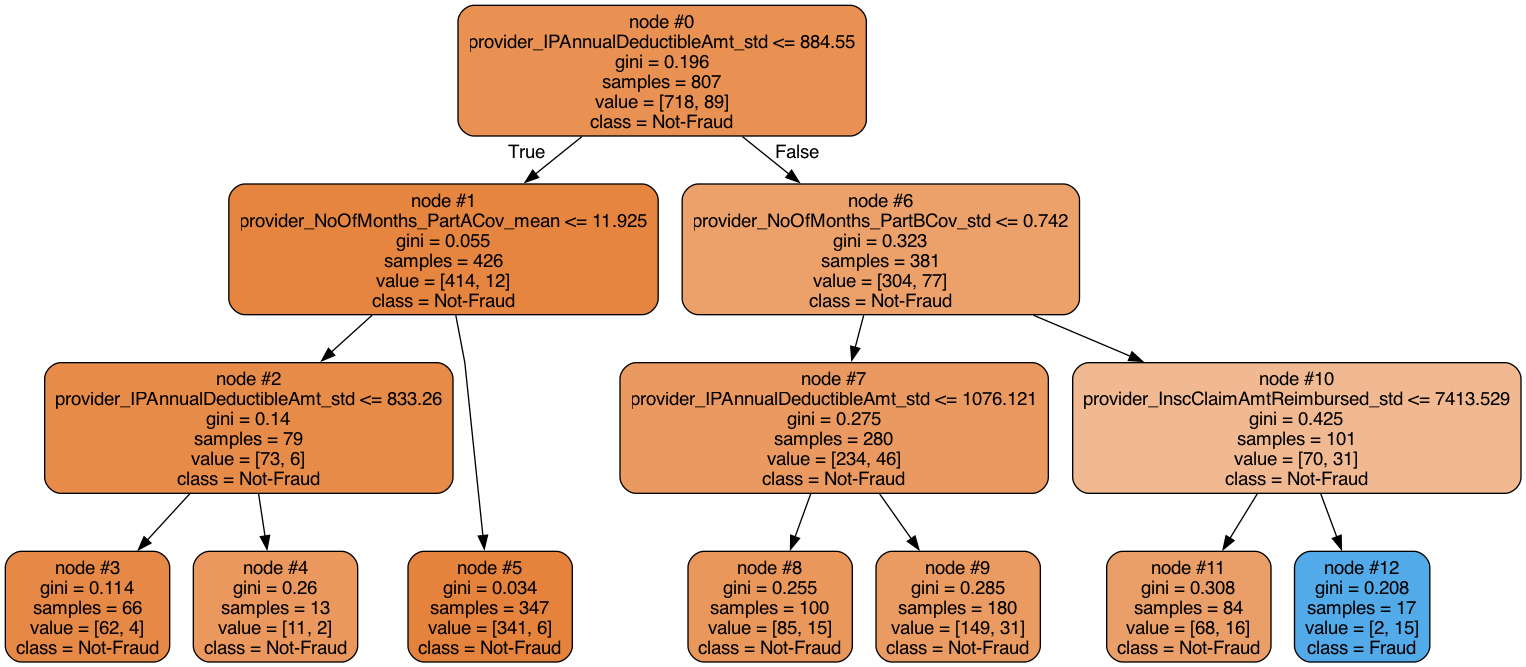

In [47]:
Image('optimal_tree_fraud.png')

In [ ]:
# import pickle
# with open('model_pkl', 'wb') as file:
#     pickle.dump(selection_model, file)
# This code was for possibly trying to save the model as a binary object to a file


AttributeError: Can't pickle local object 'solve_oct_MILP_BIN.<locals>.obj_rule'